---
layout: post
title: "Tensorflow and Albumentations"
thumbnail: "assets/img/mining_landscape.jpg"
feature-img: "assets/img/rainbow.jpg"
tags: [Computer Vision, Data augmentation, Python, TensorFlow]
---

This post is going to demonstrate how to use the [Albumentations](https://albumentations.ai/) library with TensorFlow.

<b>Table of contents</b>
* TOC
{:toc}

In [1]:
import os
import random
from functools import partial
from os.path import join
from pathlib import Path

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Loading Data into Tensorflow

First we point to our images. Our goal is to get a list of all the images that we can pass to `tf.data.Dataset`.

In [2]:
root_path = Path('E:/WallabiesAndRoosFullSize/train')

In [3]:
kang_path = root_path / 'kangaroos'
wall_path = root_path / 'wallabies'

In [4]:
kang_path_list = os.listdir(kang_path)
wall_path_list = os.listdir(wall_path)

In [5]:
kang_paths = [join(kang_path, path) for path in kang_path_list]
wall_paths = [join(wall_path, path) for path in wall_path_list]

In [6]:
paths = kang_paths + wall_paths

Let's look at what we've got

In [7]:
paths[:5]

['E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-10.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-100.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-101.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-102.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-103.jpg']

In [8]:
paths[-5:]

['E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-995.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-996.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-997.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-998.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-999.jpg']

All the images are ordered, so we'll want to shuffle them.

In [9]:
random.shuffle(paths)

In [10]:
paths[:5]

['E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-1308.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\wallabies\\wallaby-1381.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-2132.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-155.jpg',
 'E:\\WallabiesAndRoosFullSize\\train\\kangaroos\\kangaroo-2014.jpg']

We'll use TensorFlow's `StringLookup` to convert our labels into numbers. One thing I found interesting was that the labels are not 0-indexed and the value of 1 is reserved for unknown examples, so the first entry actually starts at 2.

In [11]:
vocab = ['kangaroo', 'wallaby']
layer = StringLookup(vocabulary=vocab)

In [12]:
print(layer('unknown_label').numpy())
print(layer('kangaroo').numpy())
print(layer('wallaby').numpy())

1
2
3


Now we'll make a function to parse the images and labels.

In [13]:
def parse_image(filename):
    # start with the image
    img = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(img, channels=3)
    
    # then do the label
    parts = tf.strings.split(filename, os.sep)
    label = parts[4]
    label = tf.strings.split(label, sep='-')[0]
        
    return image, label

Now pass the paths to `tf.data.Dataset`.

In [14]:
dataset_images = tf.data.Dataset.from_tensor_slices(paths)

In [15]:
dataset_images_mapped = dataset_images.map(parse_image)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [16]:
image, label = next(iter(dataset_images_mapped))

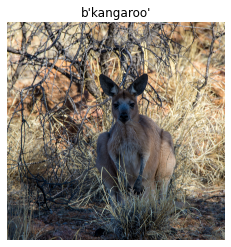

In [17]:
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy())
    plt.axis('off')

show(image, label)

## Augmentations

OK, we're good in shape. Now let's add augmentation to it.

In [18]:
transforms = A.Compose([
    # spatial-level transforms (no distortion)
        A.HorizontalFlip(p=0.5),
    # pixel-level transforms
        A.CLAHE(p=0.5),
        A.Equalize(p=0.5),
        A.Posterize(num_bits=4, p=0.5),
        A.RandomBrightness(limit=0.2, p=0.5),
        A.RandomContrast(limit=0.2, p=0.5),
        A.RandomGamma(gamma_limit=(80, 120), p=0.5),
])

In [19]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [20]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [21]:
# create dataset
ds_alb = dataset_images_mapped.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
ds_alb

<PrefetchDataset shapes: (<unknown>, ()), types: (tf.float32, tf.string)>

In [22]:
def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
    label.set_shape([])
    return img, label

In [23]:
BATCH_SIZE=32

In [24]:
ds_alb_batched = ds_alb.map(set_shapes, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_alb_batched

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.string)>

In [30]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i].decode('utf-8')}")

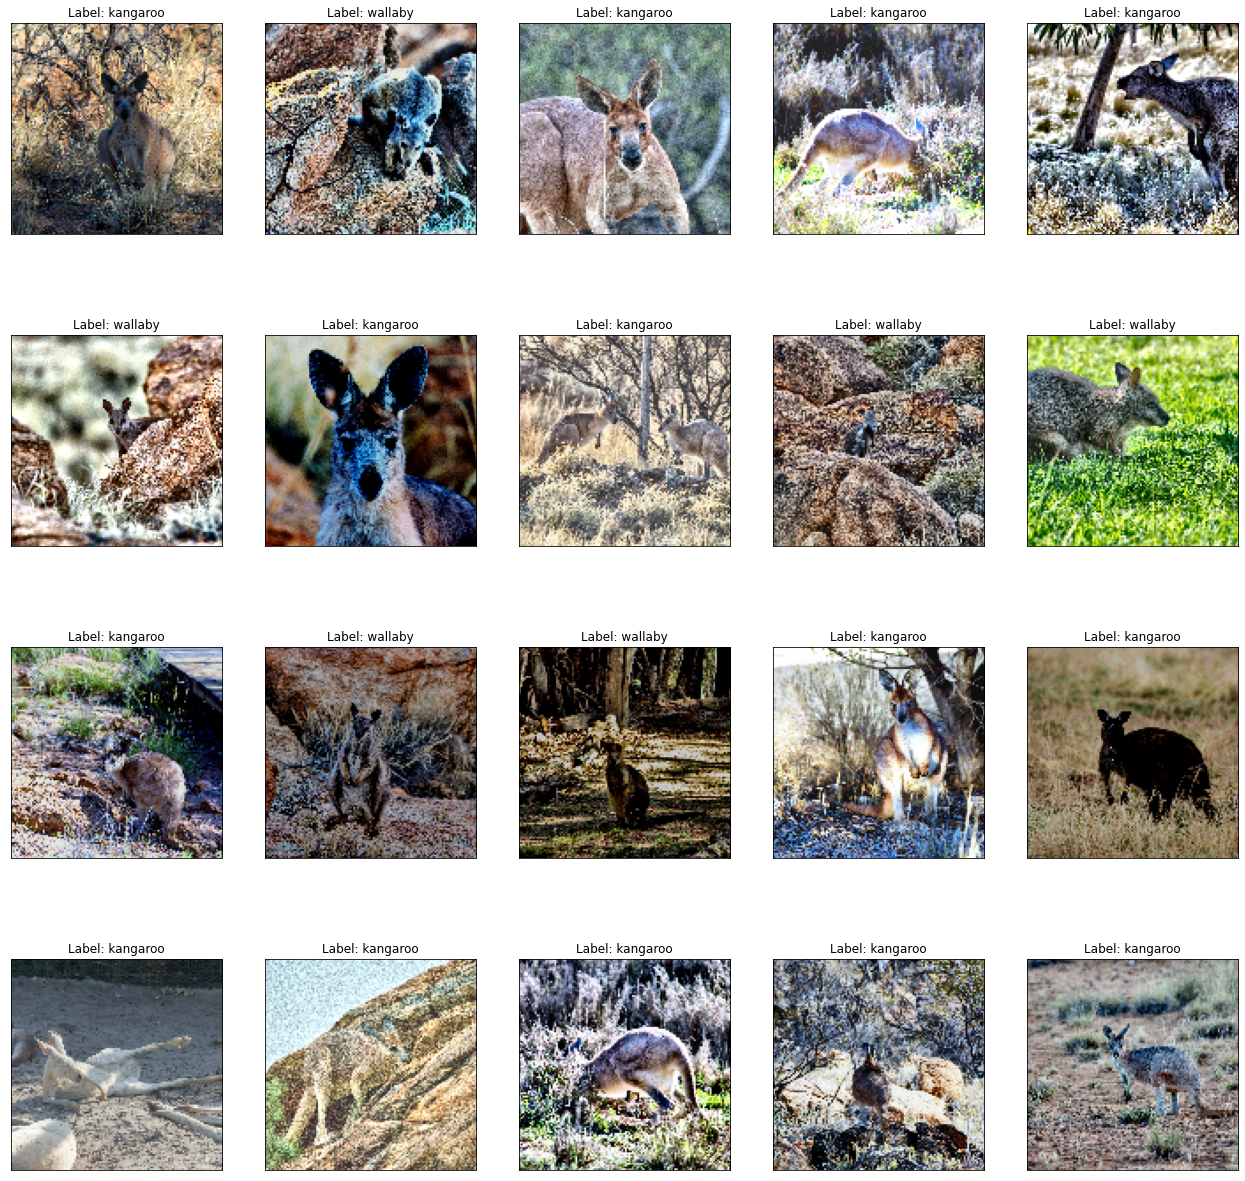

In [31]:
view_image(ds_alb_batched)